In [3]:
import os
import target_defs
import torch
import model_utils

# load the RNN
model_ensemble = []
model_path = os.path.join('models', 'gru-opt-cv10-sym')
for i in range(10):
    model = torch.jit.load(os.path.join(model_path, f'fold-{i:02d}-scripted.pt'), map_location='cpu')
    model.eval()
    model_ensemble.append(model)

abc = 'abcdefghijkl'

short_names = {'liquid': 'liq',
               'string': 'str',
               'membrane': 'mem',
               'vesicle': 'ves',
               'wormlike micelle': 'wlm',
               'spherical micelle': 'spm',
               }

In [4]:
import alphashape
import os
import numpy as np
import pandas as pd


def make_alpha_hull(xy, alpha=1):
    alpha_shape = alphashape.alphashape(xy, alpha)
    xH, yH = alpha_shape.boundary.coords.xy
    return np.vstack([xH, yH]).T


all_data = []
for keyword in ['random', 'kmeans']:
    df = pd.read_csv(os.path.join('data', 'embeddings', f'polymers-umap-{keyword}.txt'), header=None, names=['Sequence', 'Z0', 'Z1'])
    all_data.append(df)

orig_data = pd.concat(all_data)
orig_hull = make_alpha_hull(orig_data.loc[:, 'Z0':'Z1'])

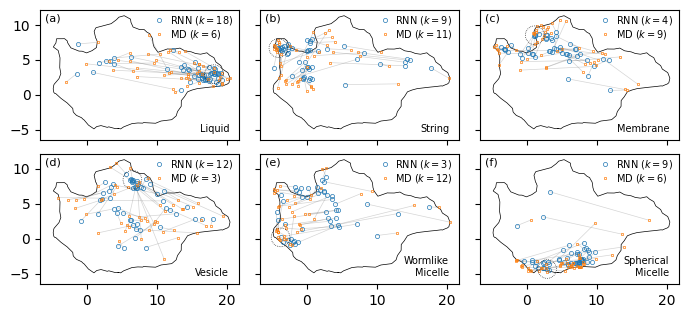

In [8]:
import json
import matplotlib.pyplot as plt


fig, axes = plt.subplots(2, 3, figsize=(7, 3.25), sharex='all', sharey='all')
fig.subplots_adjust(wspace=0, hspace=0)
axes = axes.flatten()

for i, morph in enumerate(short_names.keys()):
    
    ax = axes[i]
    
    data = {}
    for k in range(11):  # there are 10 iterations in the search
        with open(os.path.join('data', 'embeddings', 'seeded-scientific-0', f'embeddings-{short_names[morph]}.json'), 'r') as fid:
            buffer = json.load(fid)
        data.update(buffer)
    
    target = target_defs.archetype_predictions[morph]
    
    sequences = list(data.keys())  
    
    AB = {'A': 0, 'B': 1}
    int_seq = np.array([[int(AB[x]) for x in s] for s in sequences])
    
    predictions = []
    for model in model_ensemble:
        out = model_utils.predict_from_model(model, int_seq)
        predictions.append(out)
    z_pred = np.array(predictions).mean(axis=0)
    
    xy = np.vstack(list(data.values()))
    d_to_t = np.linalg.norm(xy - target, axis=1)
    n_in_d = np.sum(d_to_t < 1.34)
    r_to_t = np.linalg.norm(z_pred - target, axis=1)
    n_in_r = np.sum(r_to_t < 1.34)
    
    ax.plot(*z_pred.T, '.', ms=6, mew=0.5, mfc='none', label=f'RNN $(k={n_in_r})$', zorder=2)
    ax.plot(*xy.T, 's', ms=2, mew=0.5, mfc='none', label=f'MD $(k={n_in_d})$', zorder=3)
    ax.plot(*orig_hull.T, 'k-', lw=0.5, zorder=-1)
    ax.set_aspect('equal')
    ax.legend(fontsize=7, ncol=1, markerscale=1.0, borderpad=0.1, labelspacing=0.1, handletextpad=0.1, columnspacing=0,
              loc='upper right', bbox_to_anchor=(0.975, 0.975),  borderaxespad=0, frameon=False)
    
    ax.text(0.025, 0.975, f"({abc[i]})", fontsize=8, transform=ax.transAxes, ha='left', va='top')
    morph_str = '\n'.join(morph.title().split())
    ax.text(0.95, 0.05, f"{morph_str}", fontsize=7, transform=ax.transAxes, ha='right', va='bottom')
    
    t = np.linspace(0, 2*np.pi)
    circ_points = np.vstack([np.cos(t), np.sin(t)]).T  # radius = 1
    ax.plot(*(1.34 * circ_points + target).T, 'k:', lw=0.5, alpha=1.0, zorder=10, label='Target')
    
    lines = np.zeros([0, 2])
    for i in range(xy.shape[0]):
        lines = np.vstack([lines, xy[i], z_pred[i], np.nan*np.ones(2)])
        this = np.vstack([xy[i], z_pred[i]])
        ax.plot(*this.T, c='grey', lw=0.5, alpha=0.33, zorder=0)
    
fig.tight_layout()

In [9]:
fig.savefig(os.path.join('figures', 'rev2', 'fig_s3.pdf'), dpi=600, bbox_inches='tight')